# Import

In [43]:
# Podstawowe biblioteki
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

# Biblioteka SHAP
import shap

# Biblioteka do analizy tekstu, oraz do klasyfikacji
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Bilbioteka WordCloud
from wordcloud import WordCloud

# Biblioteka do klasyfikacji, oraz odpowiednie modele
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [44]:
# Załadowanie danych
data = pd.read_csv('realdonaldtrump.csv')
dataOriginal = data.copy()

# Usunięcie url z treści
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',content)

# Usunięcie linków twittera do zdjęć
def remove_pic(content):
	pic = re.compile(r'pic.twitter.com/\S+')
	return pic.sub(r'',content)

# Usunięcie mentionów
def remove_ment(content):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    content = mention1.sub(r'',content)
    return mention2.sub(r'',content)

# Usunięcie znaków interpunkcyjnych
def remove_punct(content):
    table = str.maketrans('', '', string.punctuation)
    return content.translate(table)

# Usunięcie html
def remove_html(content):
    html=re.compile(r'<.*?>')
    return html.sub(r'',content)

# Usunięcie emotikonów
def remove_emoji(content):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', content)

# Dekontrakcja
def decontraction(content):
    content = re.sub(r"won\'t", " will not", content)
    content = re.sub(r"won\'t've", " will not have", content)
    content = re.sub(r"can\'t", " can not", content)
    content = re.sub(r"don\'t", " do not", content)
    content = re.sub(r"can\'t've", " can not have", content)
    content = re.sub(r"ma\'am", " madam", content)
    content = re.sub(r"let\'s", " let us", content)
    content = re.sub(r"ain\'t", " am not", content)
    content = re.sub(r"shan\'t", " shall not", content)
    content = re.sub(r"sha\n't", " shall not", content)
    content = re.sub(r"o\'clock", " of the clock", content)
    content = re.sub(r"y\'all", " you all", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"n\'t've", " not have", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'d've", " would have", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ll've", " will have", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    content = re.sub(r"\'re", " are", content)
    return content

# Separacja słów od liczb
def seperate_alphanumeric(content):
    words = content
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# Znalezienie powtarzających się znaków
def cont_rep_char(content):
    tchr = content.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

# Usunięcie powtarzających się znaków
def unique_char(rep, content):
    substitute = re.sub(r'(\w)\1+', rep, content)
    return substitute

# Usunięcie stop words
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

# Stemming
def stem(text):
    tokens = []
    for token in text.split():
        tokens.append(stemmer.stem(token))
    return " ".join(tokens)

# Ustawienie wszystkich liter na małe
data['content'] = data['content'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
data['content'] = data['content'].apply(lambda x : remove_pic(x))
data['content'] = data['content'].apply(lambda x : remove_url(x))
data['content'] = data['content'].apply(lambda x : remove_ment(x))
data['content'] = data['content'].apply(lambda x : remove_punct(x))
data['content'] = data['content'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
data['content'] = data['content'].apply(lambda x : decontraction(x))
data['content'] = data['content'].apply(lambda x : seperate_alphanumeric(x))
data['content'] = data['content'].apply(lambda x : unique_char(cont_rep_char,x))
data['content'] = data['content'].apply(lambda x : remove_stopwords(x))
#data['content'] = data['content'].apply(lambda x : stem(x))

# Usunięcie duplikatów
data = data.drop_duplicates(subset=['content'])

# Usunięcie pustych wartości
data = data.dropna(subset=['content'])

# Usunięcie zbędnych kolumn
data = data.drop(['link','mentions','hashtags', 'retweets', 'favorites', 'date'], axis=1)

# NLP model

In [45]:
# Utworenie modelu
sia = SentimentIntensityAnalyzer()

# Obliczenie sentymentu
def compute_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

# Obliczenie sentymentu dla każdego tweeta
dataSentiment = data.copy()
dataSentiment['compound'], dataSentiment['negative'], dataSentiment['neutral'], dataSentiment['positive'] = zip(*data['content'].apply(compute_sentiment))

# Kategoryzacja sentymentu
def categorize_sentiment(compound):
    if compound <= -0.01:
        return 'negative'
    elif compound >= 0.01:
        return 'positive'
    else:
        return 'neutral'
dataSentiment['sentiment'] = dataSentiment['compound'].apply(categorize_sentiment)

# Prezentacja danych
pd.set_option('display.max_colwidth', None)
dataSentiment.sample(5)

,id,content,compound,negative,neutral,positive,sentiment
32111,885092844511387654,isis run soon wiped syria iraq illegal border crossings way 75 ms 13 gangs removed,-0.5574,0.205,0.795,0.000,negative
34453,1007750530976927744,fake news media said get along leaders g 7 summit canada wrong,-0.7351,0.437,0.563,0.000,negative
30319,781338220609073152,novi michigan friday 500 pm join movement tickets available americafirst trumptrain,0.2960,0.000,0.820,0.180,positive
38720,1161278978201661440,usual china said going buying big great american farmers far done said maybe different,0.6249,0.000,0.760,0.240,positive
5772,293422512740646912,thanks noel glad know helpful,0.8271,0.000,0.187,0.813,positive


# Data presentation

In [46]:
# Przykładowe dane
pd.set_option('display.max_colwidth', None)
data.sample(5)

,id,content
15838,478497641811017728,pinehurst 2 happens environmentalists take usga
29479,749965127278034944,senator tom cotton great meet press yesterday despite totally onesided interview chuck todd end result solid
41657,1233208695099666433,antitrump network whatever stoke national coronavirus panic far left network pretty much ignoring anyone interview blame president trump media refuses discuss great job professionals
19008,542687356831408129,america needs potus builds golf courses hangs please become next potus
7143,309304210636300288,wish best luck


Number of positive tweets: 23629


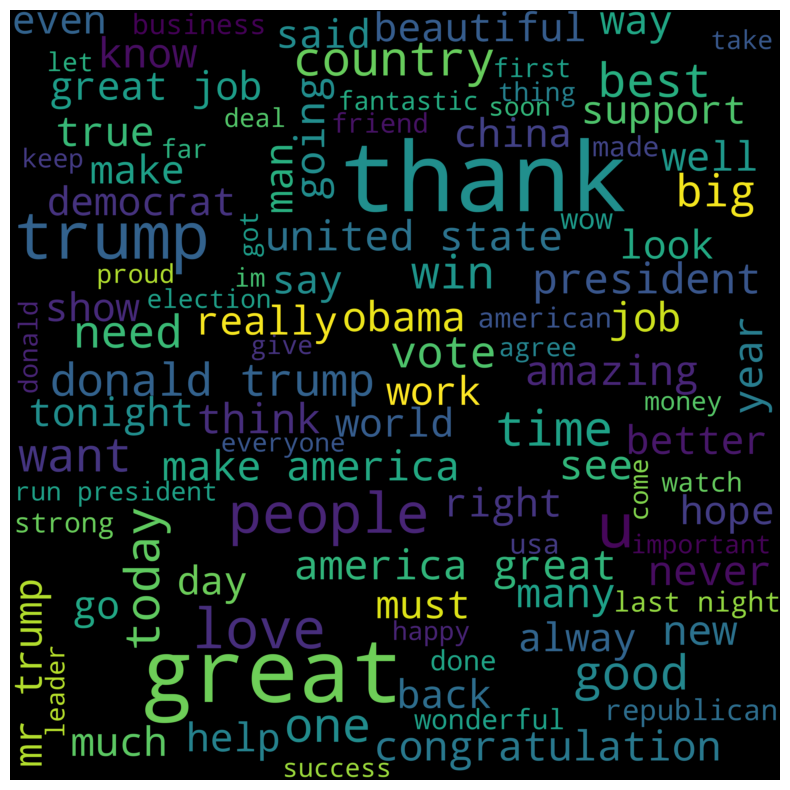

Number of negative tweets: 10473


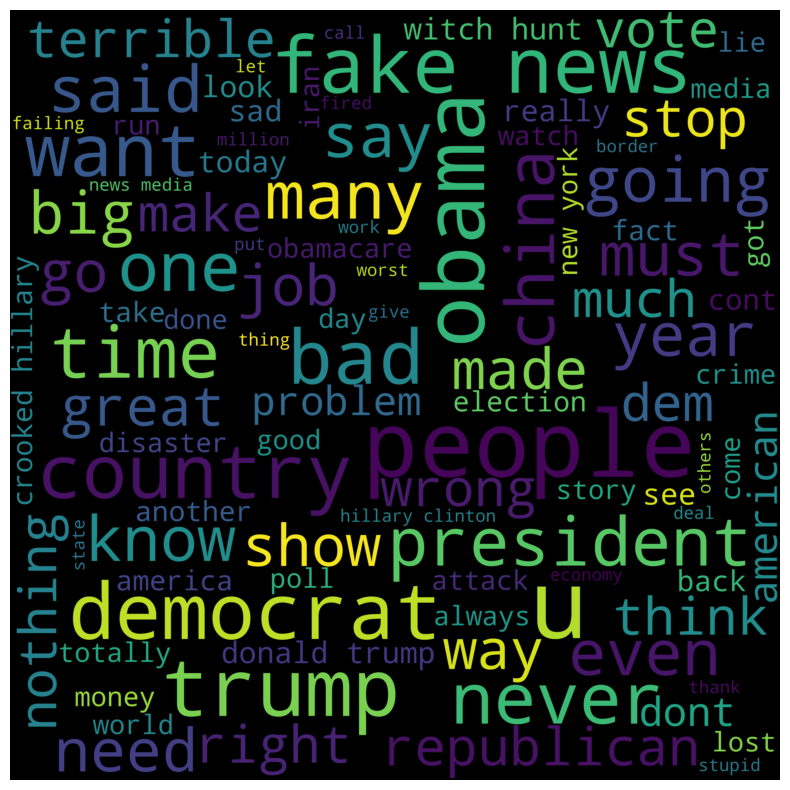

Number of neutral tweets: 6204


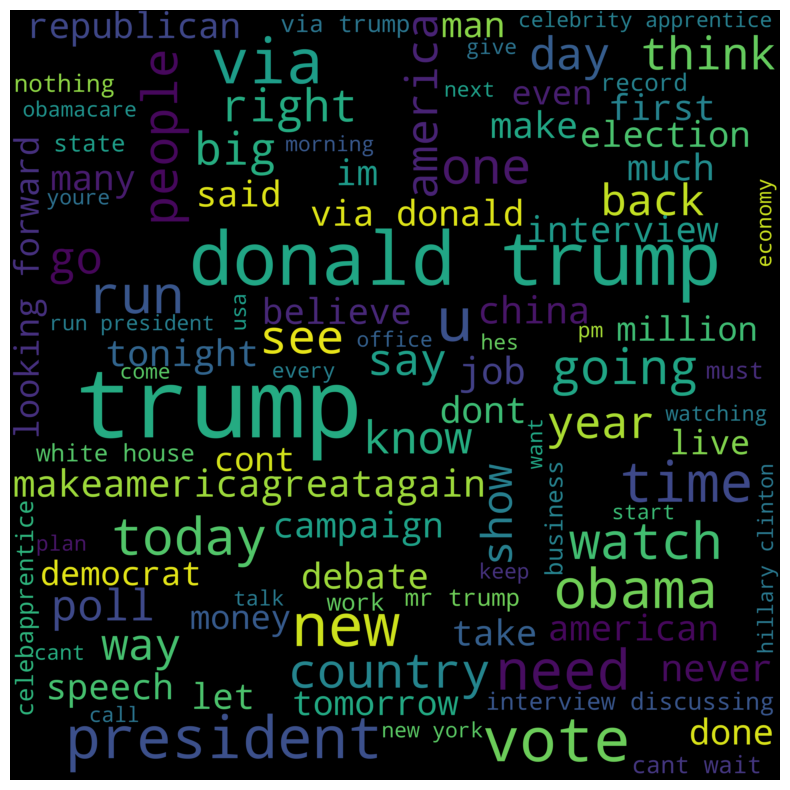

In [47]:
# Prezentacja najczęściej występujących słów w kategoriach sentymentu
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_data = dataSentiment[dataSentiment['sentiment'] == sentiment]
    print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
    word_cloud_text = ' '.join(sentiment_data['content'] )
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# SHAP analysis

In [48]:
# Przygotowanie danych do modelu
X = dataSentiment[[ 'negative', 'neutral', 'positive']]
y = dataSentiment['sentiment']

# Zakodowanie etykiet tekstowych na numeryczne
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Trening modelu Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Trening modelu XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Trening modelu CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_catboost = catboost_model.predict(X_test)

# Raport klasyfikacji
print("Random Forest")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Raport klasyfikacji
print("XGBoost")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# Raport klasyfikacji
print("CatBoost")
print(classification_report(y_test, y_pred_catboost, target_names=label_encoder.classes_))

Random Forest
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2106
     neutral       0.99      0.99      0.99      1296
    positive       0.99      0.99      0.99      4660

    accuracy                           0.99      8062
   macro avg       0.99      0.99      0.99      8062
weighted avg       0.99      0.99      0.99      8062

XGBoost
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2106
     neutral       0.99      0.98      0.99      1296
    positive       0.99      0.99      0.99      4660

    accuracy                           0.99      8062
   macro avg       0.99      0.99      0.99      8062
weighted avg       0.99      0.99      0.99      8062

CatBoost
              precision    recall  f1-score   support

    negative       0.98      0.99      0.99      2106
     neutral       1.00      0.98      0.99      1296
    positive       0.99      0.99      0.99 

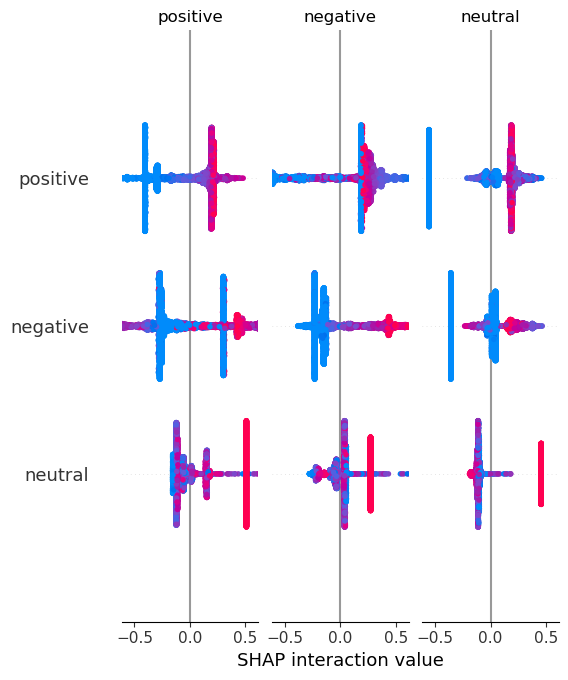

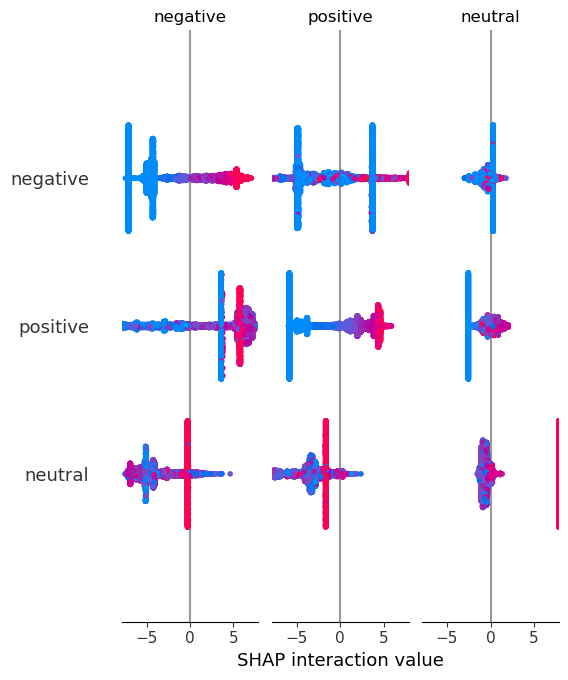

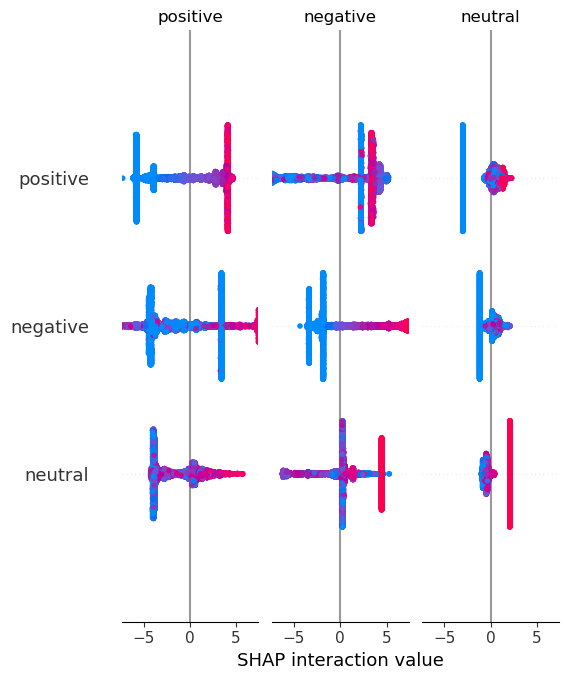

In [49]:
# Analiza SHAP dla RandomForest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji dla RandomForest
shap.summary_plot(shap_values_rf, X_test)

# Analiza SHAP dla XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji dla XGBoost
shap.summary_plot(shap_values_xgb, X_test)

# Analiza SHAP dla CatBoost
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji dla CatBoost
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# # Zapisanie wyników do nowego pliku CSV
# data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
# df = data[['number'] + list(data.columns[:-1])]
# df.to_csv('tweets_sentiment_with_model.csv', index=False)
# print(df.head())

# Conclusions